In [502]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [503]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    SGDRegressor,
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [504]:
df = pd.read_csv('data/voting_data_anonymized.tsv', sep='\t')
df.head()

,age,sex,party,party guess,race,ethnicity,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,voted 2017,voted 2018,voted 2019,voted 2020,voted 2021
0,83,M,U,R,WHITE,JEWISH,3,610.0,True,False,False,False,False,False,False,False,False,True,False,False
1,37,M,U,U,UNKNOWN,BRITISH,5,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48,F,U,D,ASIAN,EASTASIAN,3,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,True
3,61,F,U,R,WHITE,JEWISH,2,840.0,False,False,False,True,True,True,True,True,True,True,True,False
4,40,F,U,R,WHITE,BRITISH,3,700.0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False


In [505]:
# fill missing property values with mean property value
df['prop value'].fillna(int(df['prop value'].mean()), inplace=True)

In [506]:
# df.drop(df.loc[df['race']=='UNKNOWN'].index, inplace=True)
# df.drop(df.loc[df['sex']=='U'].index, inplace=True)

In [507]:
# drop all voters who were not registered in 2021
df.dropna(subset=['voted 2021'], axis=0, inplace=True)

In [508]:

# df.drop(columns=['ethnicity'], axis=1, inplace=True)
# df.replace(['BRITISH', 'FRENCH', 'GERMANIC', 'HISPANIC', 'EASTEUROPEAN', 'ITALIAN', 'NORDIC'], None, inplace=True)


In [509]:
def convert_voted_column_to_int(df, column_name):
    '''
    INPUT:
    OUTPUT:

    description
    '''
    df[column_name] = df[column_name] * 1
    df[column_name].fillna(0, inplace=True)
    return df

for i in range(2010, 2022):
    column_name = f'voted {i}'
    print(f'converting column to int: {column_name}')
    convert_voted_column_to_int(df, column_name)


converting column to int: voted 2010
converting column to int: voted 2011
converting column to int: voted 2012
converting column to int: voted 2013
converting column to int: voted 2014
converting column to int: voted 2015
converting column to int: voted 2016
converting column to int: voted 2017
converting column to int: voted 2018
converting column to int: voted 2019
converting column to int: voted 2020
converting column to int: voted 2021


In [510]:
# create dummy columns for category columns
# TODO: make it into a function
category_columns = list(df.select_dtypes(include=['object']).columns)
print(category_columns)
for i in category_columns:
    print(f'creating dummies for category column: {i}')
    df = pd.concat([df.drop(i, axis=1), 
                   pd.get_dummies(df[i], prefix=i, prefix_sep='_')], 
                   axis=1)
    

['sex', 'party', 'party guess', 'race', 'ethnicity']
creating dummies for category column: sex
creating dummies for category column: party
creating dummies for category column: party guess
creating dummies for category column: race
creating dummies for category column: ethnicity


In [511]:
import itertools

# stuff = [2016, 2017, 2018, 2019, 2020]
stuff = [2016, 2017, 2018, 2019]
# for L in range(2, len(stuff)+1):

L=3

for subset in itertools.combinations(stuff, L):
    column_name = f'voted {",".join([str(x) for x in subset])}'
    df[column_name] = 1
    print(f'adding: {column_name}')
    for i in subset:
        df[column_name] = df[column_name] & df[f'voted {i}']
    df=df.copy()

df.head()

adding: voted 2016,2017,2018
adding: voted 2016,2017,2019
adding: voted 2016,2018,2019
adding: voted 2017,2018,2019


,age,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,...,ethnicity_INDIANSUBCONTINENT,ethnicity_ITALIAN,ethnicity_JAPANESE,ethnicity_JEWISH,ethnicity_MUSLIM,ethnicity_NORDIC,"voted 2016,2017,2018","voted 2016,2017,2019","voted 2016,2018,2019","voted 2017,2018,2019"
0,83,3,610.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,48,3,640.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61,2,840.0,0,0,0,1,1,1,1,...,0,0,0,1,0,0,1,1,1,1
4,40,3,700.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,56,5,1210.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [512]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# # for i in ['age', 'precinct', 'prop value']:
# #     df[i] = scaler.fit_transform(df[i])

df2 = pd.DataFrame(scaler.fit_transform(df))

df.describe()

df.columns.shape

df.columns

Index(['age', 'precinct', 'prop value', 'voted 2010', 'voted 2011',
       'voted 2012', 'voted 2013', 'voted 2014', 'voted 2015', 'voted 2016',
       'voted 2017', 'voted 2018', 'voted 2019', 'voted 2020', 'voted 2021',
       'sex_F', 'sex_M', 'sex_U', 'party_D', 'party_R', 'party_U',
       'party guess_D', 'party guess_R', 'party guess_U', 'race_ASIAN',
       'race_BLACK', 'race_HISPANIC', 'race_UNKNOWN', 'race_WHITE',
       'ethnicity_AFRICANS', 'ethnicity_BRITISH', 'ethnicity_EASTASIAN',
       'ethnicity_EASTEUROPEAN', 'ethnicity_FRENCH', 'ethnicity_GERMANIC',
       'ethnicity_HISPANIC', 'ethnicity_INDIANSUBCONTINENT',
       'ethnicity_ITALIAN', 'ethnicity_JAPANESE', 'ethnicity_JEWISH',
       'ethnicity_MUSLIM', 'ethnicity_NORDIC', 'voted 2016,2017,2018',
       'voted 2016,2017,2019', 'voted 2016,2018,2019', 'voted 2017,2018,2019'],
      dtype='object')

In [513]:
# X=df.drop('voted 2021', axis=1)
# X=df.copy()

# X=df.drop(columns=['voted 2010','voted 2011','voted 2012','voted 2013','voted 2014',
#                     'voted 2015', 'precinct','voted 2021'])

# X=df.drop(columns=['precinct','voted 2021'], axis=1) #-0.5)*2

X = df
y=df['voted 2020']

print(X.shape, y.shape)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

df_test = X_test.copy()

drop_columns = ['voted 2020', 'voted 2021']
X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

print(X_train.shape, y_train.shape)

lm_model = TheilSenRegressor(random_state=42, max_iter=500, fit_intercept=True, verbose=True, max_subpopulation=2000)
lm_pipeline = make_pipeline(MinMaxScaler(), PolynomialFeatures(1), lm_model)
lm_pipeline.fit(X_train, y_train)

#Predict using your model
y_test_preds = lm_pipeline.predict(X_test)
y_train_preds = lm_pipeline.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(train_score, test_score)

(11278, 46) (11278,)
(8458, 44) (8458,)
Breakdown point: 0.01487588735312051
Number of samples: 8458
Tolerable outliers: 125
Number of subpopulations: 2000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.28228951899699517 0.2735603520761444


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [514]:
def get_model_coefficients(coefficients, variable_names, drop_variable_names=None):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    variable_names - names of variables corresponding to coefficients
    drop_variable_names - drop variables with these names (useful for removing poly offset)
    OUTPUT:
    df_c - a dataframe holding the coefficient and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    df_c = pd.DataFrame()
    df_c['variable'] =  variable_names
    df_c['c'] = lm_model.coef_
    df_c['abs(c)'] = np.abs(lm_model.coef_)
    for i in drop_variable_names:
        df_c = df_c.drop(labels=list(df_c.index[df_c['variable']==i]), axis=0)
    df_c = df_c.sort_values('abs(c)', ascending=False)
    return df_c

df_c = get_model_coefficients(lm_model.coef_, ['poly_offset'] + list(X_train.columns), drop_variable_names=['poly_offset'])

pal = sns.color_palette("pastel").as_hex()
df_c.sort_values('abs(c)', ascending=False).style.bar(subset=['c'], color=[pal[3], pal[2]])
# print(coef_df.sort_values('coefs', ascending=False).head(10))
# print(coef_df.sort_values('coefs', ascending=True).head(10))

,variable,c,abs(c)
13,voted 2019,0.211792,0.211792
12,voted 2018,0.099508,0.099508
43,"voted 2016,2018,2019",0.094736,0.094736
11,voted 2017,0.089852,0.089852
8,voted 2014,0.067390,0.067390
9,voted 2015,0.065874,0.065874
10,voted 2016,0.049272,0.049272
4,voted 2010,0.042330,0.042330
7,voted 2013,0.038644,0.038644
1,age,-0.037959,0.037959


In [515]:
df_test = df_test.reset_index()
df_test = pd.concat([df_test, pd.DataFrame(y_test_preds, columns=['pred 2020'])], axis=1)
df_test.set_index('index', inplace=True)

df_test['pred 2021'] = df_test['pred 2020'] + df_test['voted 2020'] * 0.314

df_test.describe()


,age,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,...,ethnicity_JAPANESE,ethnicity_JEWISH,ethnicity_MUSLIM,ethnicity_NORDIC,"voted 2016,2017,2018","voted 2016,2017,2019","voted 2016,2018,2019","voted 2017,2018,2019",pred 2020,pred 2021
count,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,...,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,50.987589,3.007801,616.023404,0.090071,0.005674,0.001064,0.089362,0.123050,0.059929,0.195745,...,0.004965,0.193617,0.025532,0.014539,0.036879,0.038652,0.075887,0.036170,0.150505,0.197827
std,18.123914,1.408663,200.762098,0.286334,0.075124,0.032605,0.285316,0.328552,0.237397,0.396843,...,0.070297,0.395202,0.157762,0.119719,0.188499,0.192800,0.264863,0.186747,0.189176,0.265797
min,18.000000,1.000000,130.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.075614,-0.075614
25%,38.000000,2.000000,480.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024987,0.026792
50%,52.000000,3.000000,590.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070819,0.074454
75%,64.000000,4.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234268,0.286722
max,99.000000,5.000000,2170.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.851600,1.148375


number of records: 2820
number of votes: 558
number of picks: 940
randomly picked: 190
voted last three: 268
voted last two: 273
voted last year: 336
predicted: 413


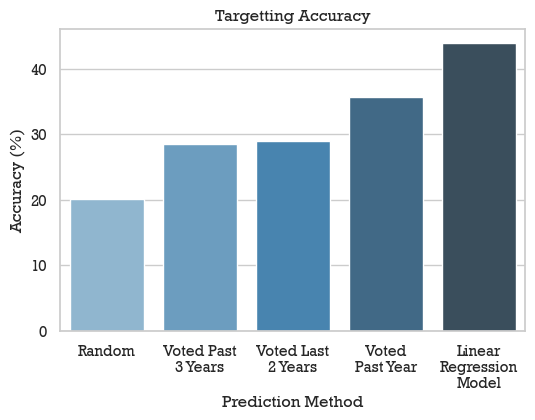

In [518]:
n_records = df_test.shape[0]
n_picks = n_records // 3
n_voted_2021 = df_test.loc[(df_test['voted 2021']==1)].shape[0]

print(f'number of records: {n_records}')
print(f'number of votes: {n_voted_2021}')
print(f'number of picks: {n_picks}')

df_test['voted last 3'] = df_test['voted 2019'] & df_test['voted 2018'] & df_test['voted 2020']
df_test['voted last 2'] = df_test['voted 2018'] & df_test['voted 2020']
df_test['voted last 1'] = df_test['voted 2020']

n_pred_correct = df_test.sort_values(['pred 2021'], ascending=False)[:n_picks]['voted 2021'].sum()
n_random_correct = df_test[:n_picks]['voted 2021'].sum()

n_last_3_correct = df_test.sort_values(['voted last 3'], ascending=False)[:n_picks]['voted 2021'].sum()
n_last_2_correct = df_test.sort_values(['voted last 2'], ascending=False)[:n_picks]['voted 2021'].sum()
n_last_1_correct = df_test.sort_values(['voted last 1'], ascending=False)[:n_picks]['voted 2021'].sum()

print(f'randomly picked: {n_random_correct}')
print(f'voted last three: {n_last_3_correct}')
print(f'voted last two: {n_last_2_correct}')
print(f'voted last year: {n_last_1_correct}')
print(f'predicted: {n_pred_correct}')

def ratio_to_percent(numerator, denominator):
    '''
    INPUT:
    numerator - the numerator of the ratio
    denominator - the denominator of the ratio
    OUTPUT:
    ratio as percentage

    Calculates the ratio, as a percentage: numerator/denominator*100
    '''
    return numerator/denominator*100

df_tmp = pd.DataFrame({
    'Method': ['Random', 'Voted Past\n3 Years', 'Voted Last\n2 Years', 'Voted\nPast Year', 'Linear\nRegression\nModel'],
    'Accuracy': [ratio_to_percent(n_random_correct, n_picks),
                 ratio_to_percent(n_last_3_correct, n_picks),
                 ratio_to_percent(n_last_2_correct, n_picks),
                 ratio_to_percent(n_last_1_correct, n_picks),
                 ratio_to_percent(n_pred_correct, n_picks)]
})


sns.set_theme()
sns.set(style='whitegrid', font="Rockwell")
palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)
ax = sns.barplot(x='Method', y='Accuracy', data=df_tmp, palette='Blues_d')
ax.set_xlabel('Prediction Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Targetting Accuracy')
plt.show()


In [517]:
q_y_test_preds = [0 if x<0.4 else 1 for x in y_test_preds]
q_y_train_preds = [0 if x<0.5 else 1 for x in y_train_preds]

# df_y_test = pd.concat([y_test, pd.Series(q_y_test_preds)])

# y_test
a=pd.DataFrame(y_test).reset_index(drop=True)
b=pd.DataFrame(q_y_test_preds) #.reset_index()

# y_train


c=pd.concat([a,b], axis=1, ignore_index=True)

n_voted = c.loc[(c[0]==1)].shape[0]
n_positive = c.loc[(c[0]==1) & (c[1]==1)].shape[0]
n_false_positive = c.loc[(c[0]==0) & (c[1]==1)].shape[0]
n_negative = c.loc[(c[0]==0) & (c[1]==0)].shape[0]
n_false_negative = c.loc[(c[0]==1) & (c[1]==0)].shape[0]

print(f'voted: {n_voted}')
print(f'positive: {n_positive}')
print(f'false positive: {n_false_positive}')
print(f'negative: {n_negative}')
print(f'false negative: {n_false_negative}')


voted: 425
positive: 190
false positive: 121
negative: 2274
false negative: 235
